# Monte Carlo

### Contents

 * Prediction
 * Control

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

sns.set()

# Prediction (Policy evaluation)

MC works for episodic learning. For each episode:
 * Track states visited in this episodes
 * Calculate the return $G_t$ for this state (using the discount $\gamma$)
 * the value function for state S is avarage return value
 
The continuous update rule is:

$$V(S_t) \leftarrow V(S_t) + \frac{1}{N(S_t)} (G_t-V(S_t))$$

This can be generalized to:

$$V(S_t) \leftarrow V(S_t) + \alpha (G_t-V(S_t))$$

This will allow to forget old episodes (Good for most typical non-stationary environments).

## Example 5.1 Blackjack

Rewards:
 * +1 - winning
 * 0  - draw
 * -1 - loosing
 
Actions 
 * 1 - Hit (take card)
 * 0 - Stick
 
Helper functions 

In [57]:
def random_card():
    """ Random card generator
        1 = Ace
    """
    return min(random.randint(1,13), 10)


def plot_values(vs):
    """Plot value function"""
    ax = sns.heatmap(vs, cmap="bwr", annot=True, fmt=".1f")
    ax.invert_yaxis()
    plt.show()

    
def random_state():
    """Random starting state"""
    return (random.randint(1,10), random.randint(12,21))


class Agent:
    
    def choose_action(self, state):
        pass
    
    def learn(self, reward, traces):
        pass
    
    def state_index(self, state):
        return (state[0]-1, state[1]-12)
    
    
def play_episode(init_state, agent):
    """ 
    Play episode from given state
    Return score and trace (list of state action paris)
    """
    state = init_state
    trace = []
    while state[1] < 22:
        action = agent.choose_action(state)
        trace.append((state, action))
        if action == 0:
            break
        card = random_card()
        state = (state[0], state[1] + card)
    if state[1] < 22:
        # player has less then 21
        dealer = state[0]
        while dealer < state[1]:
            dealer += random_card()
        if dealer == state[1]:
            return (0, trace)
        elif dealer > state[1] and dealer < 22:
            return (-1, trace)
        else:
            return (1, trace)            
    else:
        return (-1, trace)     

In [39]:
class PredictionAgent(Agent):
    """
    Predict value function for agent with specific policy.
    Here the policy is:
    If sum of card is less then 20 then HIT otherwise STICK
    """
    
    def __init__(self, alpha=0.1):
        self.player_states = 10
        self.dealer_states = 10
        self.vtable = np.zeros([self.player_states, self.dealer_states])
        self.alpha = alpha
            
    def choose_action(self, state):
        """Simple policy, when sum less the 20 then Hit"""
        if state[1] < 20:
            return 1
        else:
            return 0
    
    def learn(self, reward, traces):
        for (s, a) in traces:
            state = self.state_index(s)
            self.vtable[state[0], state[1]] += self.alpha * (reward - self.vtable[state[0], state[1]])
            
    def get_values(self):
        return self.vtable

In [65]:
agent = PredictionAgent()
print('Should Hit: %d' % agent.choose_action((5, 19)))
print('Should Stick: %d' % agent.choose_action((0, 20)))
play_episode((5, 19), agent)


Should Hit: 1
Should Stick: 0


(-1, [((5, 19), 1)])

Now we will use the following policy:

**Always take card is sum is less then 20.**

In [76]:
def simulate(agent, num_episodes):
    for _ in range(num_episodes):
        start_state = random_state()
        r, trace = play_episode(start_state, agent)
        agent.learn(r, trace)

    plot_values(agent.get_values())       

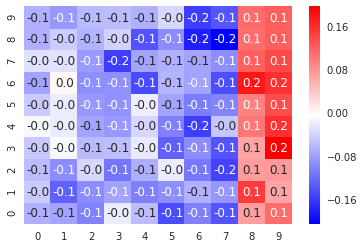

In [77]:
simulate(PredictionAgent(0.01), 10**3)

After 1M episodes

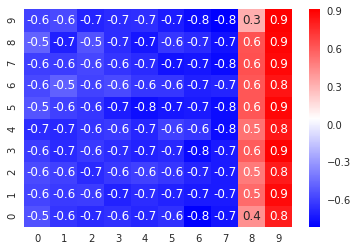

In [78]:
simulate(PredictionAgent(0.01), 10**6)

# Control

In the Model Free we can't use Value function. This is because we don't know which state we will end up taking specific action. That's why in this situation we will learn Q(s,a) function.

## Example 5.3 Solving Blackjack

Use Monte Carlo with ES (Exploring Starts)

In [94]:
class ControlAgent(Agent):
    
    def __init__(self, alpha=0.1):
        self.player_states = 10
        self.dealer_states = 10
        self.num_actions = 2
        self.qtable = np.zeros([self.player_states, self.dealer_states, self.num_actions])
        self.alpha = alpha
            
    def choose_action(self, state):
        """Simple policy, when sum less the 20 then Hit"""
        s = self.state_index(state)
        if np.random.rand() < 0.99:
            return np.argmax(self.qtable[s[0], s[1], :])
        else:
            return np.random.choice(range(2))        
    
    def learn(self, reward, traces):
        for (s, a) in traces:
            state = self.state_index(s)
            self.qtable[state[0], state[1], a] += self.alpha * (reward - self.qtable[state[0], state[1], a])
            
    def get_values(self):
        return np.max(self.qtable, axis=2)
    
    def optimal_policy(self):
        p = np.zeros([self.player_states, self.dealer_states])
        for i in range(self.player_states):
            for j in range(self.dealer_states):
                p[i, j] = np.argmax(self.qtable[i, j, :])
        return p

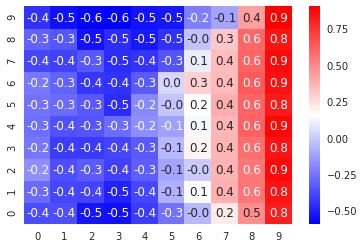

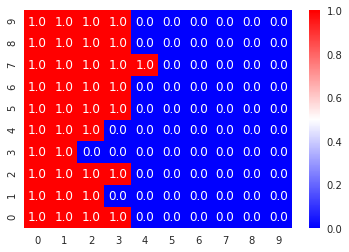

In [96]:
agent = ControlAgent(0.01)
simulate(agent, 10**7)
plot_values(agent.optimal_policy())